# USNM 2P data analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import pprint
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack, view_interactive_plot
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()

# Logger level
logger.setLevel(logging.INFO)

## General parameters

 24/11/2021 18:07:04: input data directory:
/Users/tlemaire/Documents/data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1
 24/11/2021 18:07:04: figures directory:
/Users/tlemaire/Documents/data/yiyuan/figs


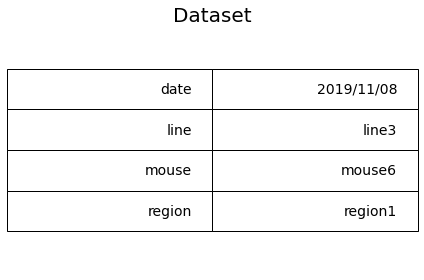

In [3]:
# Input data directory
dataroot = get_data_root() # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
line = 'line3'
datadir = os.path.join(dataroot, date, mouse, region)
logger.info(f'input data directory:\n{datadir}')

# Figures dictionary
figsdir = os.path.join(split_path_at(dataroot, 'raw')[0], 'figs')
if not os.path.isdir(figsdir):
    os.makedirs(figsdir)
logger.info(f'figures directory:\n{figsdir}')
figs = {}

# Create table figure summarizing dataset info
figs['dataset_info'] = plot_table({
    'date': f'{date[4:]}/{date[:2]}/{date[2:4]}',
    'line': line,
    'mouse': mouse,
    'region': region
    })

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References'], include_patterns=[line])
logger.info(f'Identified folders containing TIF files:\n{pprint.pformat([os.path.basename(x) for x in tif_folders])}')

 24/11/2021 18:07:04: Identified folders containing TIF files:
['line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 'line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 'line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 'line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-754',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-751',
 'line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755',
 'line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747',
 'line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-757',
 'line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753']


In [5]:
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 24/11/2021 18:07:04: extracting aquisition settings...


{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (301.0752688172, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 0.16, 'YAxis': 0.0, 'ZAxis': 0.65},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 

### Merge TIFs into stack

In [6]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

 24/11/2021 18:07:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 24/11/2021 18:07:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 24/11/2021 18:07:06: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 24/11/2021 18:07:07: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 24/11/2021 18:07:07: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 24/11/2021 18:07:07: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize stack for a randomly chosen run

 24/11/2021 18:07:29: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 24/11/2021 18:07:30: initializing stack viewer
 24/11/2021 18:07:30: stack size: (1600, 256, 256)
 24/11/2021 18:07:30: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5646.37it/s]

 24/11/2021 18:07:30: intensity range: 32 - 1906
 24/11/2021 18:07:30: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4812.49it/s]

 24/11/2021 18:07:31: initializing stack viewer
 24/11/2021 18:07:31: stack size: (1600, 256, 256)
 24/11/2021 18:07:31: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5738.00it/s]

 24/11/2021 18:07:31: intensity range: 32 - 1906
 24/11/2021 18:07:31: rendering stack view...


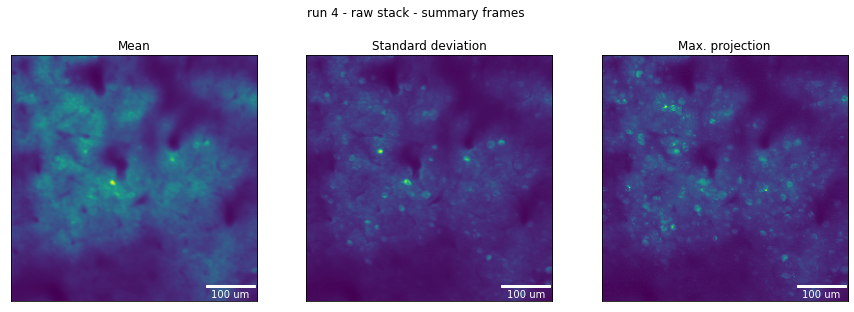

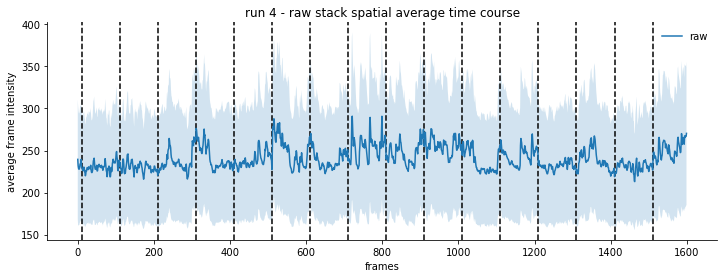

In [8]:
# Run index
irun = 4

from plotters import plot_stack_timecourse

# Load stack
raw_stack = loadtif(raw_stack_fpaths[irun])

# Plot stack summary images
figs[f'raw_stack_run{irun}'] = plot_stack_summary(
    raw_stack, title=f'run {irun} - raw stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot time course of the stack spatial average
figs[f'raw_stack_timecourse_run{irun}'] = plot_stack_timecourse(
    {'raw': raw_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, title=f'run {irun} - raw stack')

# View stack 
view_stack({
    'raw': raw_stack_fpaths[irun]}, title=f'run {irun}', ilabels=i_stim_frames_run)

We notice a significant amount of Speckle noise in the acquired images, especially on the frames corresponding to stimulation episodes.

## Substitution of stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

In [9]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

 24/11/2021 18:07:33: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 24/11/2021 18:07:33: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 24/11/2021 18:07:33: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 24/11/2021 18:07:33: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 24/11/2021 18:07:33: "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3

### View stack substitution output for the same run

 24/11/2021 18:07:35: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/interpolated/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 24/11/2021 18:07:36: initializing stack viewer
 24/11/2021 18:07:36: stack size: (1600, 256, 256)
 24/11/2021 18:07:36: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5115.91it/s]

 24/11/2021 18:07:36: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5705.36it/s]

 24/11/2021 18:07:36: intensity range: 32 - 1906
 24/11/2021 18:07:36: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4733.63it/s]

 24/11/2021 18:07:38: initializing stack viewer
 24/11/2021 18:07:38: stack size: (1600, 256, 256)
 24/11/2021 18:07:38: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5362.59it/s]

 24/11/2021 18:07:38: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5549.24it/s]

 24/11/2021 18:07:38: intensity range: 32 - 1906
 24/11/2021 18:07:38: rendering stack view...


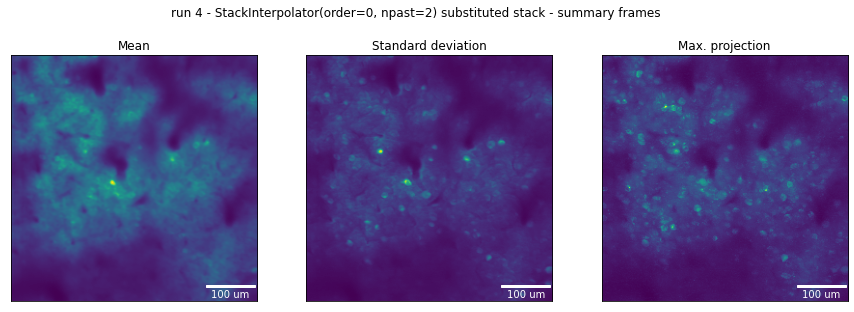

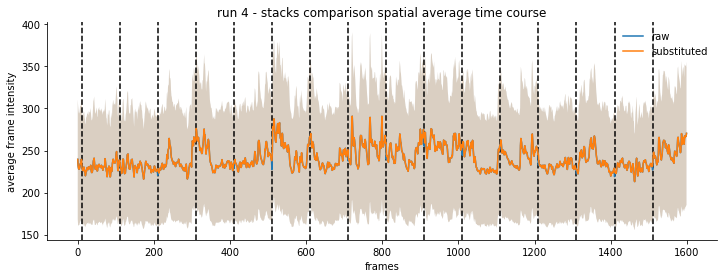

In [10]:
# Load interpolated stack for the same run
subsituted_stack = loadtif(substituted_stack_fpaths[irun])

# Plot interpolated stack summary images
figs[f'interp_stack_run{irun}'] = plot_stack_summary(
    subsituted_stack, title=f'run {irun} - {si} substituted stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot comparative time course of the stacks spatial average
figs[f'interp_stack_timecourse_run{irun}'] = plot_stack_timecourse({
    'raw': raw_stack_fpaths[irun],
    'substituted': substituted_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw and inteprolated stacks side-by-side
view_stack({
    'raw': raw_stack_fpaths[irun],
    si: substituted_stack_fpaths[irun]},
    title=f'run {irun}', ilabels=i_stim_frames_run, norm=True)

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [11]:
# Define Kalman filter
kd = KalmanDenoiser(G=.5, V=0.05, npad=10)  # real filter object
# kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

 24/11/2021 18:07:41: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 24/11/2021 18:07:41: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 24/11/2021 18:07:41: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 24/11/2021 18:07:41: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 24/11/2021 18:07:41: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order

### View stack denoising output for a particular stack

 24/11/2021 18:07:44: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif"
 24/11/2021 18:07:44: initializing stack viewer
 24/11/2021 18:07:44: stack size: (1600, 256, 256)
 24/11/2021 18:07:44: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5730.68it/s]

 24/11/2021 18:07:45: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5704.27it/s]

 24/11/2021 18:07:45: intensity range: 63 - 1414
 24/11/2021 18:07:45: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4812.49it/s]

 24/11/2021 18:07:46: initializing stack viewer
 24/11/2021 18:07:46: stack size: (1600, 256, 256)
 24/11/2021 18:07:46: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 5713.11it/s]

 24/11/2021 18:07:46: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5693.93it/s]

 24/11/2021 18:07:47: intensity range: 63 - 1414
 24/11/2021 18:07:47: rendering stack view...


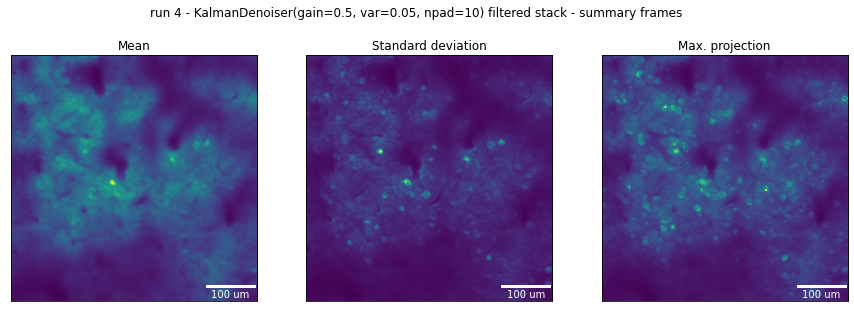

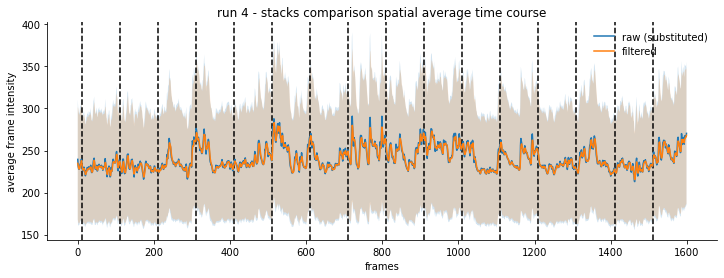

In [12]:
# Load denoised stack for the same run
filtered_stack = loadtif(filtered_stack_fpaths[irun])

# Plot denoised stack summary images
figs[f'filtered_stack_run{irun}'] = plot_stack_summary(
    filtered_stack, title=f'run {irun} - {kd} filtered stack',
    um_per_px=daq_settings['micronsPerPixel'])

# Plot comparative time course of the stacks spatial average
figs[f'filtered_stack_timecourse_run{irun}'] = plot_stack_timecourse({
    'raw (substituted)': substituted_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    }, ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')

# Visualize raw, inteprolated and denoised stacks side-by-side
view_stack({
    'raw (substituted)': substituted_stack_fpaths[irun],
    kd: filtered_stack_fpaths[irun]},
    ilabels=i_stim_frames_run, norm=True)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [13]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

 24/11/2021 18:07:54: parsed frame rate = 3.56 fps
 24/11/2021 18:07:54: Suite2p input directory:
/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1


### Run suite2p with custom options

In [14]:
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

 24/11/2021 18:07:55: running suite2p 0.10.2 with the following options:
{'denoise': True, 'fs': 3.56, 'nonrigid': True, 'reg_tif': True, 'tau': 1.25}
 24/11/2021 18:07:55: data will be saved in suite2p base directory "suite2p_denoise_fs_3.56_reg_tif_tau_1.25"
 24/11/2021 18:07:55: found suite2p output files in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/new_experiments_201911/11082019/mouse6/region1/suite2p_denoise_fs_3.56_reg_tif_tau_1.25/plane0"
 24/11/2021 18:07:55: run options match 100% -> ignoring
 24/11/2021 18:07:55: empty data path -> no run


### Load suite2p ouput data

In [15]:
# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
all_s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = all_s2p_data.pop('ops')

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Log info table
logger.info('output info table corresponding to suite2p processing order:')
output_info_table

 24/11/2021 18:07:57: extracted data contains 516 ROIs
 24/11/2021 18:07:57: output info table corresponding to suite2p processing order:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  ntrials
run                                                                           
0    line3           100           0.2  3.56     0.00    50.0     757       16
1    line3           100           0.2  3.56     0.10    50.0     755       16
2    line3           100           0.2  3.56     0.20    50.0     754       16
3    line3           100           0.2  3.56     0.40    50.0     753       16
4    line3           100           0.2  3.56     0.05    50.0     756       16
5    line3           100           0.2  3.56     0.60    50.0     752       16
6    line3           100           0.2  3.56     0.80     5.0     748       16
7    line3           100           0.2  3.56     0.80    10.0     747       16
8    line3           100           0.2  3.56     0.80    20.0     746       16
9    line3           100           0.2  3.56     0.80    30.0     745       16
10   line3           100           0.2  3.56     0.80    40.0     744       16
11   line3           100           0.2  3.56     0.80    50.0     743       16
12   line3           100           0.2  3.56     0.80    60.0     749       16
13   line3           100           0.2  3.56     0.80    70.0     750       16
14   line3           100           0.2  3.56     0.80    80.0     751       16

### Plot suite2p summary images

 24/11/2021 18:07:58: plotting suite2p registered images...


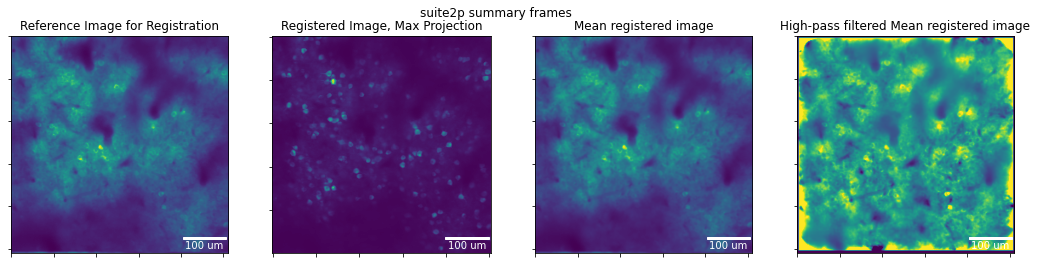

In [16]:
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

### Plot suite2p registration offsets

 24/11/2021 18:07:58: plotting suite2p registration offsets...


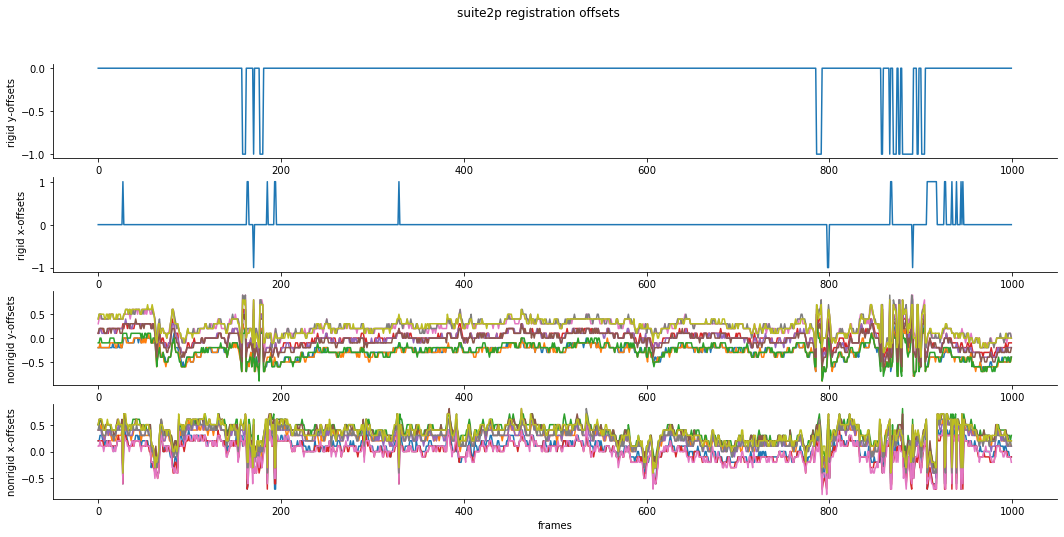

In [17]:
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, 'suite2p registration offsets')

### Visualize registered stack (for the same run as before)

In [18]:
istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
for i in range(nruns):
    istimframes_stacked[i] += i * nframes_per_run
istimframes_stacked = istimframes_stacked.flatten()
irun_eq = output_to_input_mapping[irun]
runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
view_stack(
    s2p_ops, title=f'registered stack (run {irun} -> output {irun_eq})',
    bounds=runbounds, ilabels=istimframes_stacked)

 24/11/2021 18:08:01: initializing stack viewer
 24/11/2021 18:08:01: stack size: (24000, 256, 256)
 24/11/2021 18:08:01: frame frange: [8000, 9599]
 24/11/2021 18:08:01: computing stack intensity range across 8000 - 9599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 6271.36it/s]

 24/11/2021 18:08:02: intensity range: 50 - 393
 24/11/2021 18:08:02: rendering stack view...


### Compare average frame intensity for specific run

That is a good opportunity to check that our mapping of input stacks to suite2p output stacks is correct.

 24/11/2021 18:08:11: initializing stack viewer
 24/11/2021 18:08:11: stack size: (1600, 256, 256)
 24/11/2021 18:08:11: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:00<00:00, 5603.36it/s]

 24/11/2021 18:08:12: intensity range: 32 - 1906



100%|██████████| 1600/1600 [00:00<00:00, 5711.97it/s]

 24/11/2021 18:08:12: intensity range: 63 - 1414
 24/11/2021 18:08:12: adding 16 delimiters



100%|██████████| 1600/1600 [00:00<00:00, 4753.47it/s]

 24/11/2021 18:08:13: initializing stack viewer
 24/11/2021 18:08:13: stack size: (24000, 256, 256)
 24/11/2021 18:08:13: frame frange: [8000, 9599]
 24/11/2021 18:08:13: computing stack intensity range across 8000 - 9599 frame range...



100%|██████████| 1600/1600 [00:00<00:00, 6162.26it/s]

 24/11/2021 18:08:13: intensity range: 50 - 393



100%|██████████| 1600/1600 [00:01<00:00, 1467.16it/s]


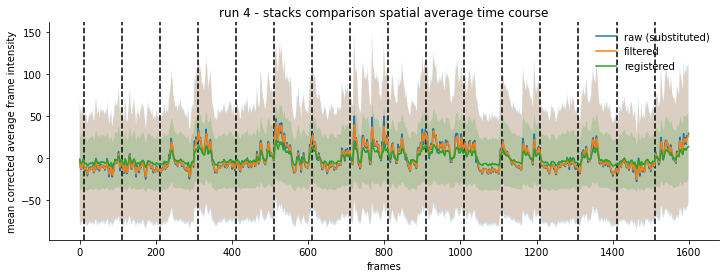

In [19]:
# Plot comparative time course of the stacks spatial average
fig = plot_stack_timecourse({
    'raw (substituted)': substituted_stack_fpaths[irun],
    'filtered': filtered_stack_fpaths[irun]
    }, 
    correct=True,
    ilabels=i_stim_frames_run, title=f'run {irun} - stacks comparison')
figs[f'registered_stack_timecourse_run{irun}'] = plot_stack_timecourse(
    s2p_ops, title='registered', bounds=runbounds, ax=fig.axes[0], correct=True)


### Inspect suite2p ROIs

 24/11/2021 16:17:58: plotting suite2p identified ROIs...


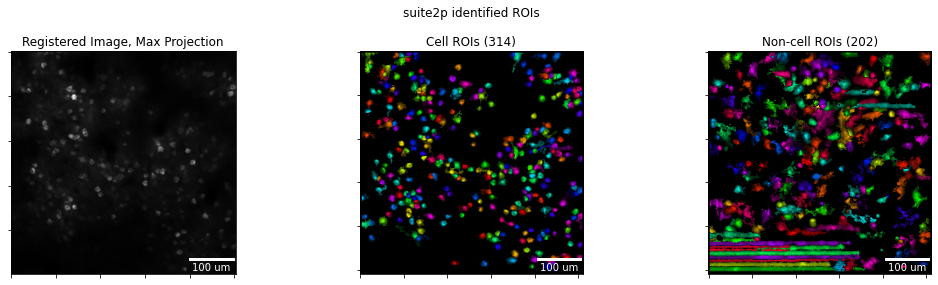

In [19]:
figs['identified_ROIs'] = plot_suite2p_ROIs(
    all_s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'])

### Get fluorescence timeseries data

In [20]:
all_Ftimeseries = arrays_to_dataframe({
    Label.F_ROI: all_s2p_data['F'],
    Label.F_NEU: all_s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled {describe_dataframe_index(all_Ftimeseries)} fluorescence timeseries dataframe:')
all_Ftimeseries

 24/11/2021 16:18:00: assembled 516 ROIs x 24000 frames fluorescence timeseries dataframe:


F_ROI (a.u.)  F_neu (a.u.)
ROI frame                            
0   0        181.027191    143.495407
    1        192.738037    147.502747
    2        193.219131    147.717438
    3        189.408936    146.339447
    4        178.830154    143.121094
...                 ...           ...
515 23995    105.690468    106.046509
    23996    107.762451    106.790695
    23997    105.807793    105.348839
    23998    102.846825    105.206718
    23999    104.054207    106.857880

[12384000 rows x 2 columns]

## Post-processing

### Filter out non-cell ROIs

In [21]:
iscell = all_s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
cell_Ftimeseries = all_Ftimeseries.loc[(icells)]
cell_s2p_data = filter_s2p_data(all_s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(cell_Ftimeseries)} fluorescence timeseries dataframe')

 24/11/2021 16:18:01: filtered to 314 ROIs x 24000 frames fluorescence timeseries dataframe


### Discard outliers based on morphological properties

 24/11/2021 16:18:01: updating dataset...
 24/11/2021 16:18:01: filtered to 312 ROIs x 24000 frames fluorescence timeseries dataframe
 24/11/2021 16:18:01: plotting suite2p identified ROIs...
 24/11/2021 16:18:02: identified 2 outlier(s):


compact  solidity   npix  npix_soma  radius  aspect_ratio   skew  \
ROI                                                                     
159    False     False   True      False   False         False  False   
172     True     False  False      False   False         False  False   

     is_outlier  
ROI              
159        True  
172        True

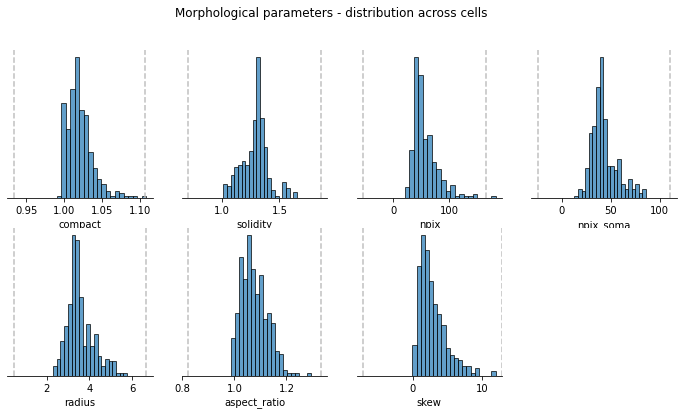

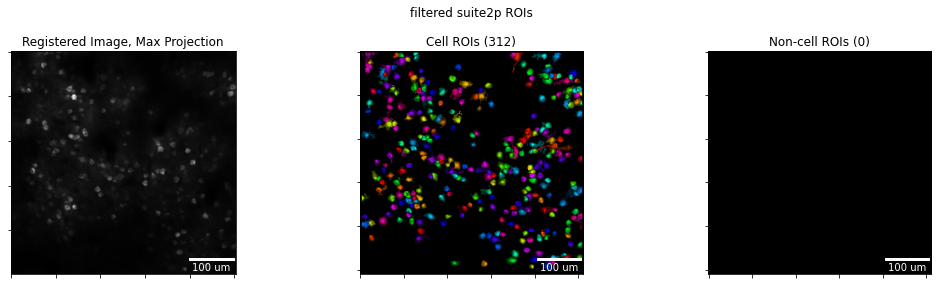

In [22]:
# Plot distributions and identify outliers
pkeys = [
    'compact',
    'solidity',
    'npix',
    'npix_soma',
    'radius',
    'aspect_ratio',
    'skew',
]
figs['morpho_params_cells'], df_outliers = plot_parameter_distributions(
    cell_s2p_data, pkeys, zthr=5)
df_outliers['is_outlier'] = df_outliers[pkeys].sum(axis=1).astype(bool)
df_outliers[Label.ROI] = icells
df_outliers = df_outliers.set_index(Label.ROI)
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = cell_Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(cell_s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'])

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### Select subset of ROIs and runs to plot

 24/11/2021 16:18:02: randomly selecting 3 ROI(s) for plotting (index(es) = [ 89 134 381])
 24/11/2021 16:18:02: selecting run 11 with parameters P = 0.80 MPa and DC = 5000 % for plotting
 24/11/2021 16:18:02: sub-indexing data...
 24/11/2021 16:18:02: filtering data...
 24/11/2021 16:18:02: cross-checking filters...
 24/11/2021 16:18:02: plotting 2 fluorescence trace(s)...
 24/11/2021 16:18:02: adding 16 delimiters


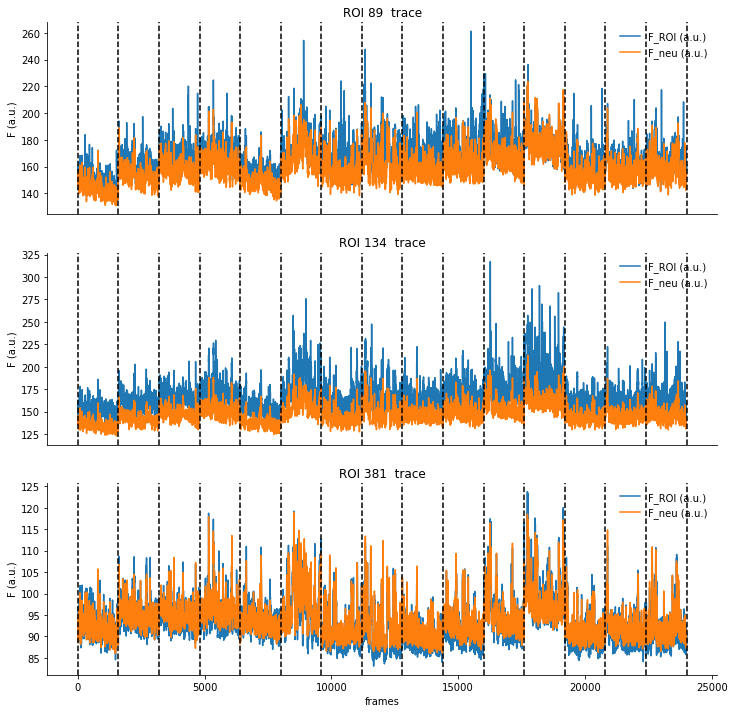

In [23]:
# Select subset of ROIs
iROIs = Ftimeseries.index.unique(level=Label.ROI)
iROI_plt = np.random.choice(iROIs, size=3)
iROI_plt.sort()  # sort ROIs subset to ensure consistent looping
logger.info(f'randomly selecting {len(iROI_plt)} ROI(s) for plotting (index(es) = {iROI_plt})')

# Find run with high P and DC to plot
irun_plt = output_info_table[
    (output_info_table[Label.P] == P_REF) & (output_info_table[Label.DC] == DC_REF)
    ].index[0]
logger.info(f'selecting run {irun_plt} with parameters P = {P_REF:.2f} MPa and DC = {DC_REF * 1e2:.0f} % for plotting')

# Plot longitudinal fluorescence traces for selected ROI
run_delimiters = np.arange(nruns + 1) * nframes_per_run
figs['raw_F_traces'] = plot_traces(
    Ftimeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
    iROI=iROI_plt, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

 24/11/2021 16:18:03: subtracting neuropil background with alpha = 0.7 ...
 24/11/2021 16:18:03: sub-indexing data...
 24/11/2021 16:18:03: filtering data...
 24/11/2021 16:18:03: cross-checking filters...
 24/11/2021 16:18:03: plotting 1 fluorescence trace(s)...
 24/11/2021 16:18:03: adding 16 delimiters


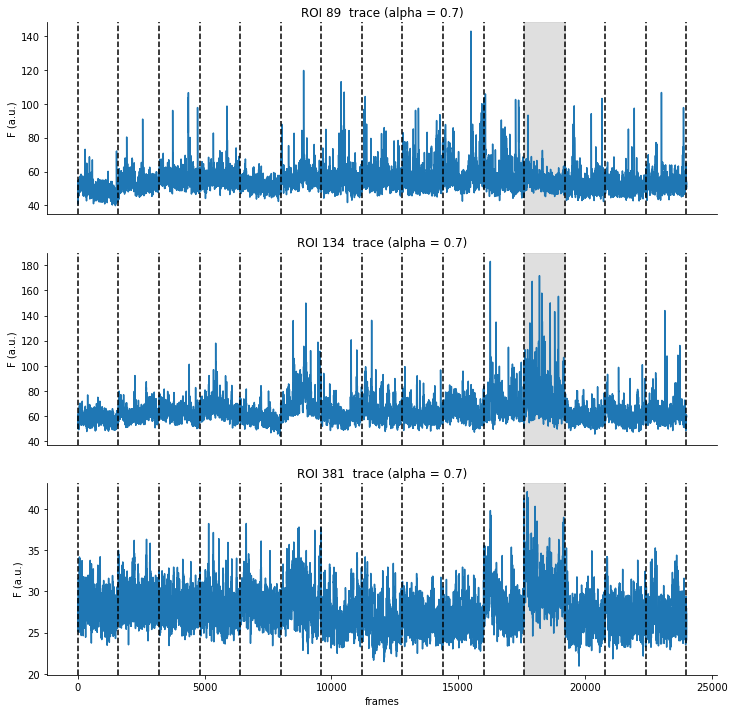

In [24]:
# Subtract neuropil background fluorescence each ROI of interest
from constants import ALPHA
logger.info(f'subtracting neuropil background with alpha = {ALPHA} ...')
Ftimeseries[Label.F] = Ftimeseries[Label.F_ROI] - ALPHA * Ftimeseries[Label.F_NEU]

# Plot longitudinal fluorescence traces for selected ROI
run_delimiters = np.arange(nruns + 1) * nframes_per_run
figs['F_trace'] = plot_traces(
    Ftimeseries[[Label.F]],
    iROI=iROI_plt, delimiters=run_delimiters,
    title=f'alpha = {ALPHA}')
# Highlight selected run on figure
for ax in figs['F_trace'].axes:
    ax.axvspan(run_delimiters[irun_plt], run_delimiters[irun_plt + 1], color='silver', alpha=0.5);

### Split the data into separate runs

 24/11/2021 16:18:03: splitting fluorescence data into 15 separate runs...
 24/11/2021 16:18:05: sub-indexing data...
 24/11/2021 16:18:05: filtering data...
 24/11/2021 16:18:05: cross-checking filters...
 24/11/2021 16:18:05: plotting 1 fluorescence trace(s)...
 24/11/2021 16:18:05: adding 16 delimiters


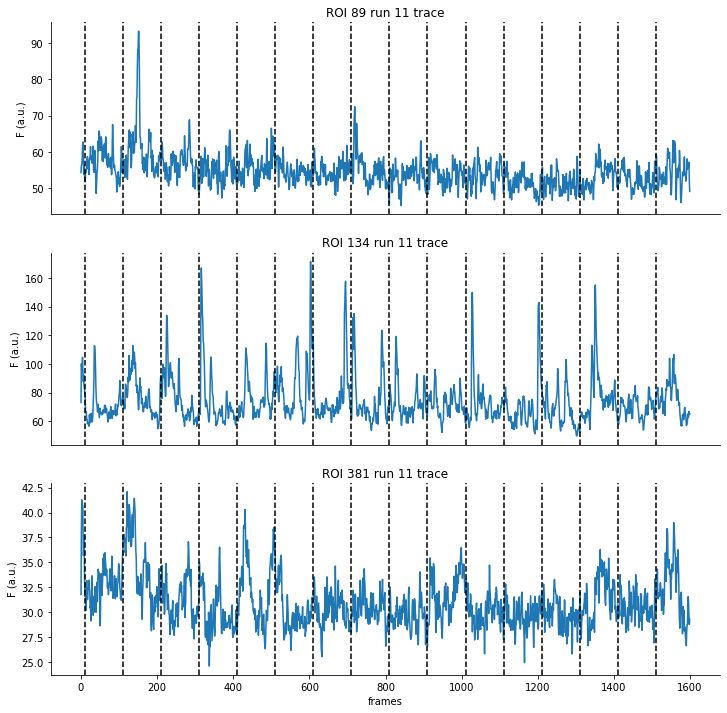

In [25]:
# Split the data into separate runs
Ftimeseries = separate_runs(Ftimeseries, nruns)
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# Plot fluorescence timecourse of selected ROI for selected run
figs[f'F_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.F]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Compute time-varying fluorescence baseline

To do so, we apply a low percentile sliding window over the entire fluorescence timecourse.

This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

 24/11/2021 16:18:05: computing signal baseline as 5th percentile of 30.0s (107 frames) sliding window


4680it [00:06, 715.81it/s]                          

 24/11/2021 16:18:12: sub-indexing data...


 24/11/2021 16:18:12: filtering data...
 24/11/2021 16:18:12: cross-checking filters...
 24/11/2021 16:18:12: ambiguous y-labeling for more than 1 signal
 24/11/2021 16:18:12: plotting 2 fluorescence trace(s)...
 24/11/2021 16:18:12: adding 16 delimiters


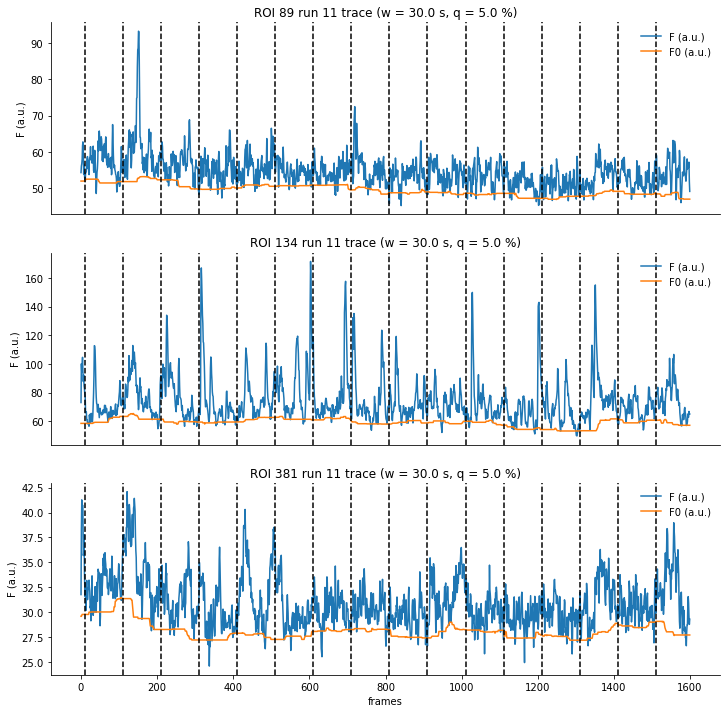

In [26]:
from constants import BASELINE_WLEN, BASELINE_QUANTILE
Ftimeseries[Label.F0] = compute_baseline(
    Ftimeseries[Label.F], fps, BASELINE_WLEN, BASELINE_QUANTILE)

# Plot original and baseline fluorescence of selected ROI for selected run
figs[f'F_F0_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.F, Label.F0]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters,
    title=f'w = {BASELINE_WLEN:.1f} s, q = {BASELINE_QUANTILE * 1e2:.1f} %')

### Remove outliers with fluctuating baseline

For downstream analysis steps, we wish to consider only cells who exhibiit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

 24/11/2021 16:18:12: computing baseline relative standard deviation...
 24/11/2021 16:18:13: identifying outliers...
 24/11/2021 16:18:13: updating dataset...
 24/11/2021 16:18:14: filtered to 311 ROIs x 15 runs x 1600 frames fluorescence dataframe
 24/11/2021 16:18:14: identified 1 outlier(s):


max F0 RSD  is_outlier
ROI                        
394    3.067435        True

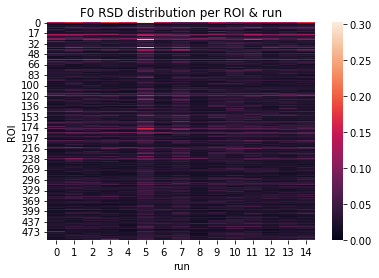

In [27]:
from constants import BASELINE_RSD_THR

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.std(x) / np.abs(x.mean()))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
ax = sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0)
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
Ftimeseries = Ftimeseries.loc[(df_outliers.iloc[ivalids].index)]
logger.info(f'filtered to {describe_dataframe_index(Ftimeseries)} fluorescence dataframe')

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### Apply baseline correction

Downstream analysis steps require fluorescence signals with a relatively flat activity baseline. Therefore, fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

 24/11/2021 16:18:14: subtracting mean-corrected baseline from signals...
 24/11/2021 16:18:20: sub-indexing data...
 24/11/2021 16:18:20: filtering data...
 24/11/2021 16:18:20: cross-checking filters...
 24/11/2021 16:18:20: ambiguous y-labeling for more than 1 signal
 24/11/2021 16:18:20: plotting 2 fluorescence trace(s)...
 24/11/2021 16:18:20: adding 16 delimiters


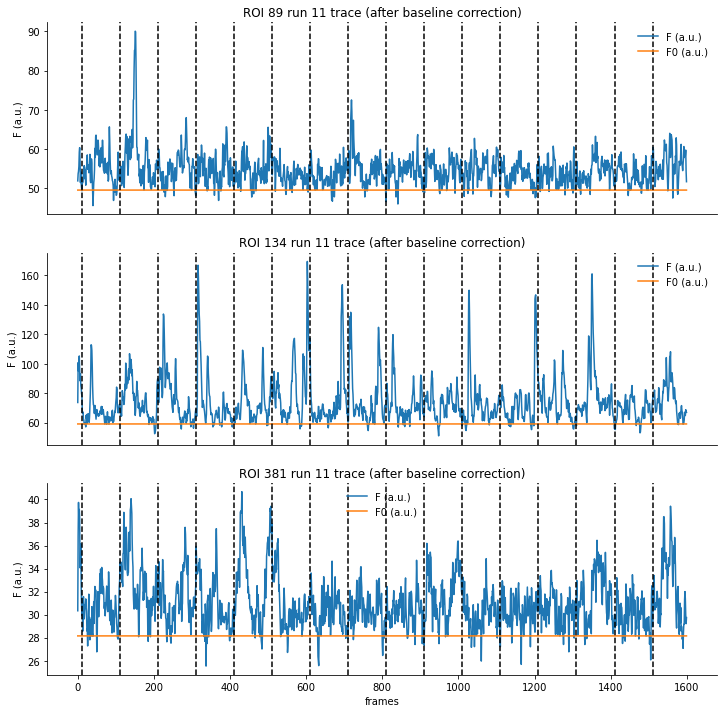

In [28]:
logger.info('subtracting mean-corrected baseline from signals...')
# Compute mean baseline value per ROI & run
F0_mean = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
# Apply baseline corretor to both fluorescence and baseline signals
baseline_corrector = Ftimeseries[Label.F0] - F0_mean
Ftimeseries[Label.F] -= baseline_corrector
Ftimeseries[Label.F0] -= baseline_corrector

# Plot baseline-corrected fluorescence signal and baseline of selected ROI for selected run
figs[f'F_F0_trace_run{irun_plt}_corrected'] = plot_traces(
    Ftimeseries[[Label.F, Label.F0]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters,
    title='after baseline correction')

### Split the fluorescence data into separate trials and remove first trials of each condition

<span style="color:red">NOTE: on the acquisition side, nothing is wrong with the first trial of each condition. However, since the different runs were fed together into suite2p (in order to improve ROI identification), the resulting fluorescence timecourses for each ROI were computed by suite2p under the assumption of time continuity, which is NOT the case during run-to-run transitions. We therefore discard the first trial of each run, since the fluorescence data is physiologically invalid around these transitions.</span>

In [29]:
# Split fluorescence data into separate trials
Ftimeseries = separate_trials(Ftimeseries, ntrials_per_run)

# Discard first trial of each run (if not done already)
i_first_trial = Ftimeseries.index.unique(level=Label.TRIAL)[0]
if i_first_trial == 0:
    logger.info('removing first trial of each run...')
    Ftimeseries = Ftimeseries.loc[:, :, 1:, :]
else:
    logger.warning('first trial already removed -> ignoring')

 24/11/2021 16:18:21: splitting fluorescence data into 16 separate trials...
 24/11/2021 16:18:23: removing first trial of each run...


### Compute relative fluorescence change

 24/11/2021 16:18:23: computing relative change in fluorescence...
 24/11/2021 16:18:33: sub-indexing data...
 24/11/2021 16:18:34: filtering data...
 24/11/2021 16:18:34: cross-checking filters...
 24/11/2021 16:18:34: plotting 1 fluorescence trace(s)...
 24/11/2021 16:18:34: adding 16 delimiters


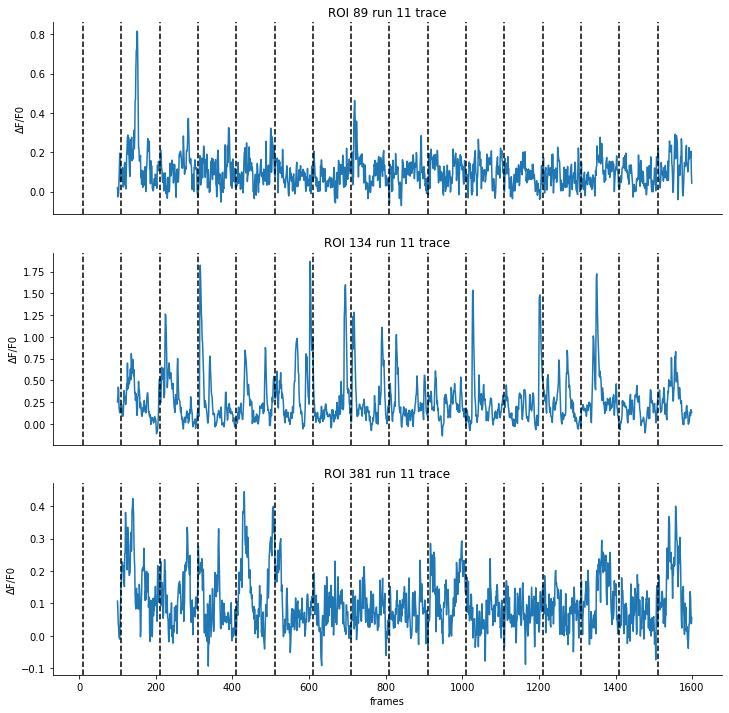

In [30]:
# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
F0 = Ftimeseries[Label.F0].groupby([Label.ROI, Label.RUN]).median()  # median of the baseline over each run
Ftimeseries[Label.DFF] = (Ftimeseries[Label.F] - F0) / F0

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
figs[f'dFF_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.DFF]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)

### Create statistics dataframe

In [31]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: Ftimeseries.index.unique(k) for k in Ftimeseries.index.names}

# Create Fstats dataframes
logger.info('creating statistics dataframe')
Fstats = pd.DataFrame()

 24/11/2021 16:18:34: creating statistics dataframe


### Compute dFF noise amplitude and resulting dFF z-score traces

 24/11/2021 16:18:34: estimating dFF noise regime threshold...
 24/11/2021 16:18:36: computing dFF noise amplitude from event free periods...
 24/11/2021 16:18:42: computing z-scores associated with relative change in fluorescence...
 24/11/2021 16:18:52: plotting ΔF/F0 noise amplitude per ROI & run - all trials...
 24/11/2021 16:18:53: sub-indexing data...
 24/11/2021 16:18:53: filtering data...
 24/11/2021 16:18:53: cross-checking filters...
 24/11/2021 16:18:53: plotting 1 fluorescence trace(s)...
 24/11/2021 16:18:53: adding 16 delimiters


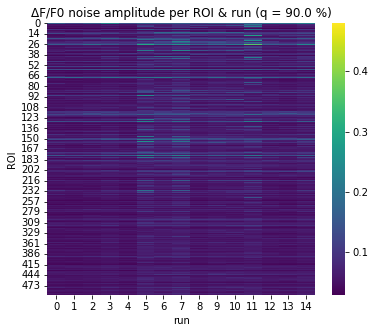

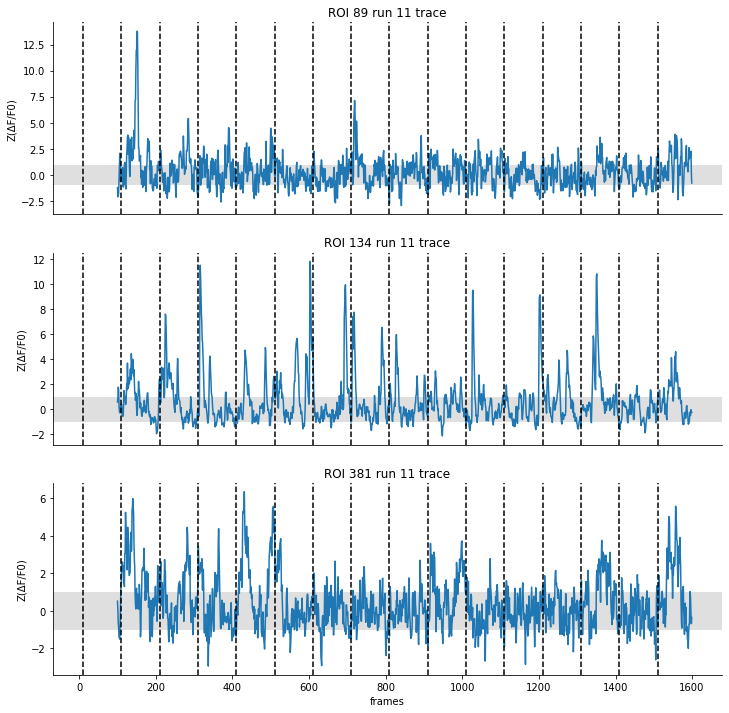

In [32]:
from constants import DFF_NOISE_QUANTILE
# For each ROI & run, compute dFF noise threshold as a specific quantile of the dFF distribution
logger.info('estimating dFF noise regime threshold...')
dFF_noise_thr = Ftimeseries[Label.DFF].groupby([Label.ROI, Label.RUN]).quantile(DFF_NOISE_QUANTILE)

logger.info('computing dFF noise amplitude from event free periods...')
# Copy dFF and set all elements above noise regime to NaN
dFF_noise = Ftimeseries[Label.DFF].copy()
dFF_noise[dFF_noise - dFF_noise_thr > 0] = np.nan
# Estimate dFF noise level and variation range within noise regime
dFF_noise_med = dFF_noise.groupby([Label.ROI, Label.RUN]).median()
dFF_noise_amp = dFF_noise.groupby([Label.ROI, Label.RUN]).std()

# Normalize dFF traces by dFF noise level -> dFF z-score
logger.info('computing z-scores associated with relative change in fluorescence...')
Ftimeseries[Label.ZSCORE] = (Ftimeseries.loc[:, Label.DFF] - dFF_noise_med) / dFF_noise_amp

# Repeat dFF noise along trials -> Fstats table
Fstats[Label.DFF_NOISE_AMP] = repeat_along_new_dim(
    dFF_noise_amp.to_frame(),
    Label.TRIAL, index_dims[Label.TRIAL])
Fstats[Label.DFF_NOISE_LEVEL] = repeat_along_new_dim(
    dFF_noise_med.to_frame(),
    Label.TRIAL, index_dims[Label.TRIAL])

# Plot average dFF noise amplitude distribution per ROI & run
figs['dFF_noise_amp_map'] = plot_stat_heatmap(
    Fstats, Label.DFF_NOISE_AMP, cmap='viridis',
    title=f'q = {DFF_NOISE_QUANTILE * 1e2:.1f} %')

# Plot consecutive trials of dFF z-score of selected ROI for selected run
figs[f'zscore_trace_run{irun_plt}'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
# Plot estimated noise range on the z-score trace
for ax in figs[f'zscore_trace_run{irun_plt}'].axes:
    ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Identify trials with pre-stimulus activity

 24/11/2021 16:18:53: analyzing fluorescence activity in pre-stimulus intervals...
 24/11/2021 16:18:53: identified 16096 trials over 69975 (23.0 %) with significant pre-stimulus activity (Z(ΔF/F0) > 1.645)
 24/11/2021 16:18:54: sub-indexing data...
 24/11/2021 16:18:54: filtering data...
 24/11/2021 16:18:54: cross-checking filters...
 24/11/2021 16:18:54: plotting 1 fluorescence trace(s)...
 24/11/2021 16:18:54: adding 16 delimiters


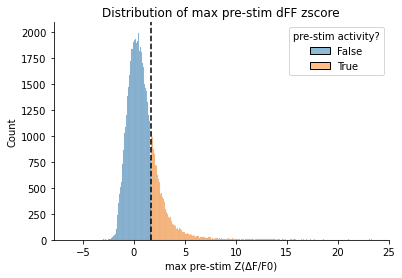

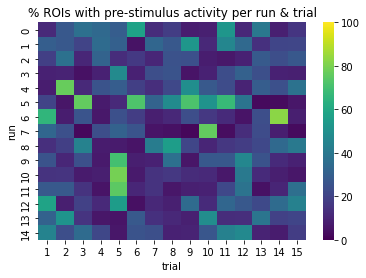

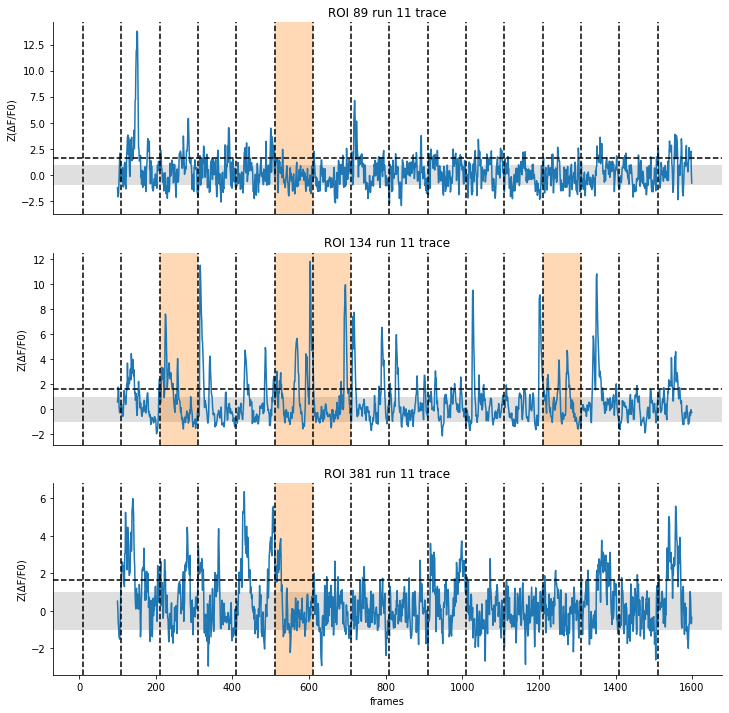

In [33]:
from constants import FrameIndex, ZSCORE_PRESTIM_THR

logger.info('analyzing fluorescence activity in pre-stimulus intervals...')
# Identify max dFF z-score in pre-stimulus window for each trial
zscore_prestim = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
Fstats[Label.MAX_ZSCORE_PRESTIM] = zscore_prestim.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).max()

# Classify pre-stimulus state based on this metrics
Fstats[Label.PRESTIM_ACTIVITY] = Fstats[Label.MAX_ZSCORE_PRESTIM] > ZSCORE_PRESTIM_THR
nacts, ntot = Fstats[Label.PRESTIM_ACTIVITY].sum(), len(Fstats)
logger.info(f'identified {nacts} trials over {ntot} ({nacts / ntot * 1e2:.1f} %) with significant pre-stimulus activity ({Label.ZSCORE} > {ZSCORE_PRESTIM_THR})')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim_zscore_level_dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(Fstats, x=Label.MAX_ZSCORE_PRESTIM, hue=Label.PRESTIM_ACTIVITY, ax=ax)
ax.axvline(ZSCORE_PRESTIM_THR, ls='--', c='k')
ax.set_xlim(ax.get_xlim()[0], 25)
ax.set_title('Distribution of max pre-stim dFF zscore')

# Plot number of ROIs with pre-stimulus activity for each run & trial (to see if there is a trend)
nROIs = len(Fstats.index.unique(level=Label.ROI))
pct_prestim_per_run_trial = Fstats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum() / nROIs * 1e2
figs['pct_prestim_activity_map'], ax = plt.subplots()
sns.heatmap(pct_prestim_per_run_trial.unstack(), ax=ax, cmap='viridis', vmin=0, vmax=100)
ax.set_title('% ROIs with pre-stimulus activity per run & trial')

# Plot consecutive trials of dFF z-score of selected ROI for selected run 
figs[f'zscore_trace_run{irun_plt}_labeled'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
for ir, ax in zip(iROI_plt, figs[f'zscore_trace_run{irun_plt}_labeled'].axes):
    # Plot estimated noise range on the z-score traces
    ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
    # Plot pre-stimulus activity threshold and label trials with pre-stim activity
    ax.axhline(ZSCORE_PRESTIM_THR, ls='--', c='k');
    mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_plt)

### Compute relative z-score change w.r.t. pre-stim value for each trial

In [34]:
# Extract pre-stimulus z-score level
logger.info('extracting z-score pre-stim level for each trial...')
z_prestim = Ftimeseries.loc[
    pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
z_onset = z_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Subtract pre-stim z-score value to get relative z-score
logger.info('computing relative z-scores changes (w.r.t. pre-stim level) for each trial...')
Ftimeseries[Label.REL_ZSCORE] = (Ftimeseries.loc[:, Label.ZSCORE] - z_onset)

 24/11/2021 16:18:56: extracting z-score pre-stim level for each trial...
 24/11/2021 16:18:56: computing relative z-scores changes (w.r.t. pre-stim level) for each trial...


### Compute stimlulus-evoked peak z-score w.r.t. pre-stim value

 24/11/2021 16:19:02: identifying peak relative z-score in response window...
 24/11/2021 16:19:05: identified 69354 response peaks over 69975 trials (success rate = 99.1 %)
 24/11/2021 16:19:07: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - all trials...
 24/11/2021 16:19:07: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - False trials...
 24/11/2021 16:19:07: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] per ROI & run - True trials...


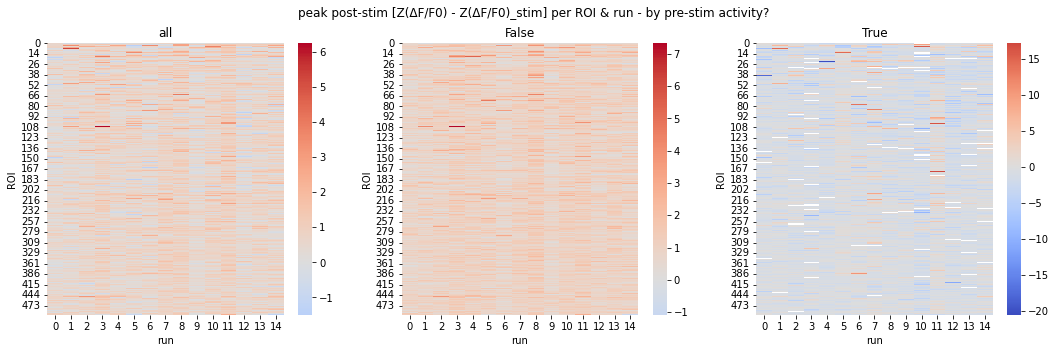

In [35]:
# Identify peak z-score in analysis window
logger.info('identifying peak relative z-score in response window...')
relz_window = Ftimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.RESPONSE], Label.REL_ZSCORE]
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] = relz_window.groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).agg(find_response_peak)
npeaks, ntrials = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM].notna().sum(), len(Fstats)
logger.info(f'identified {npeaks} response peaks over {ntrials} trials (success rate = {npeaks / ntrials * 1e2:.1f} %)')

# Plot average peak z-score per ROI & run
figs[f'peak_rel_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM, cmap='coolwarm', groupby=Label.PRESTIM_ACTIVITY)

### Identify stimulus-evoked responses

 24/11/2021 16:19:07: identifying stimulus-evoked responses...
 24/11/2021 16:19:08: sub-indexing data...
 24/11/2021 16:19:08: filtering data...
 24/11/2021 16:19:08: cross-checking filters...
 24/11/2021 16:19:08: plotting 1 fluorescence trace(s)...
 24/11/2021 16:19:08: adding 16 delimiters


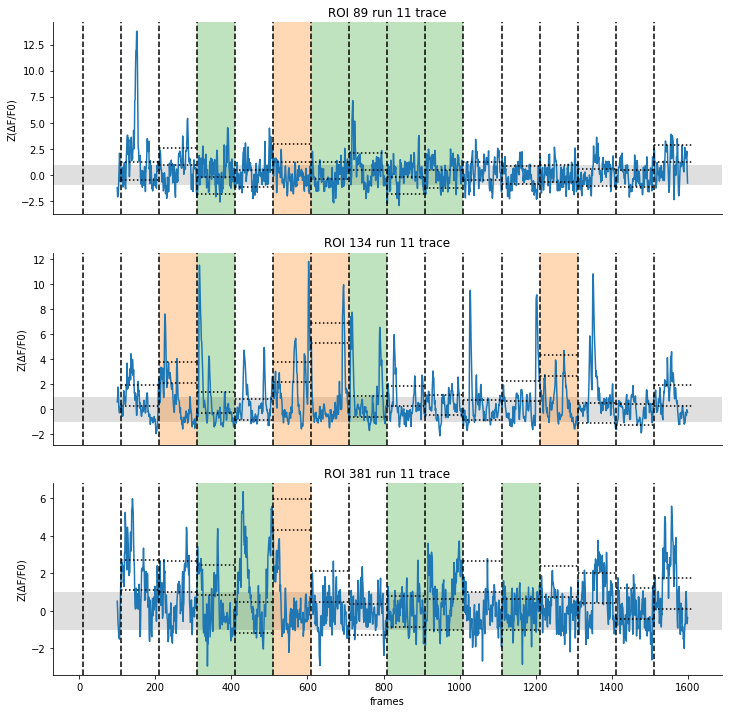

In [36]:
logger.info('identifying stimulus-evoked responses...')
# Identify "proper" responses as those with a z-score above defined threshold 
Fstats[Label.IS_RESP] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM] > REL_ZSCORE_RESPONSE_THR

# Plot consecutive trials of relative z-score of selected ROI for selected run
figs[f'zscore_trace_run{irun_plt}_labeled2'] = plot_traces(
    Ftimeseries[[Label.ZSCORE]],
    iROI=iROI_plt, irun=irun_plt, delimiters=stim_delimiters)
# Label trials with pre-stim activity and those with post-stimlus response
for (ir, ax) in zip(iROI_plt, figs[f'zscore_trace_run{irun_plt}_labeled2'].axes):
    # Plot estimated noise range on the z-score traces
    ax.axhspan(-1, 1, fc='silver', ec=None, alpha=0.5);
    # Plot pre-stim level and post-stim detection threshold for each trial
    z0 = z_onset.loc[ir, irun_plt]
    istart, z0 = z0.index.values, z0.values
    xstart = stim_delimiters[istart]
    for zoffset, ls in zip([0., REL_ZSCORE_RESPONSE_THR], [':', ':']): 
        ax.hlines(
            z0 + zoffset, xstart, xstart + NFRAMES_PER_TRIAL,
            colors='k', linestyles=ls, zorder=3)
    # Label trials with pre-stim activity and those with post-stim response
    mark_trials(ax, Fstats[Label.PRESTIM_ACTIVITY], ir, irun_plt)
    mark_trials(ax, Fstats[Label.IS_RESP], ir, irun_plt, color='C2')

### Inspect response success rate

 24/11/2021 16:19:10: plotting trial-averaged success rate per ROI & run - all trials...
 24/11/2021 16:19:10: plotting trial-averaged success rate per ROI & run - False trials...
 24/11/2021 16:19:10: plotting trial-averaged success rate per ROI & run - True trials...
 24/11/2021 16:19:12: plotting trial-averaged success rate - all trials...
 24/11/2021 16:19:12: plotting trial-averaged success rate - False trials...
 24/11/2021 16:19:12: plotting trial-averaged success rate - True trials...


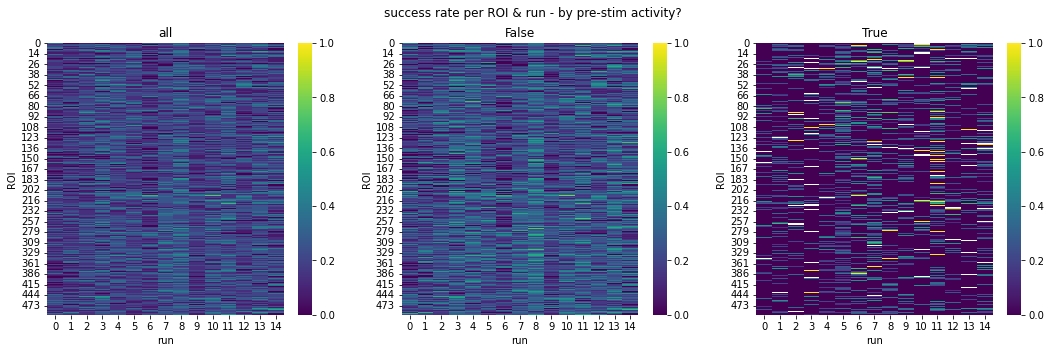

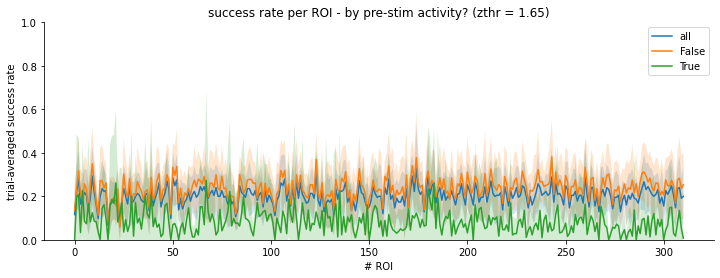

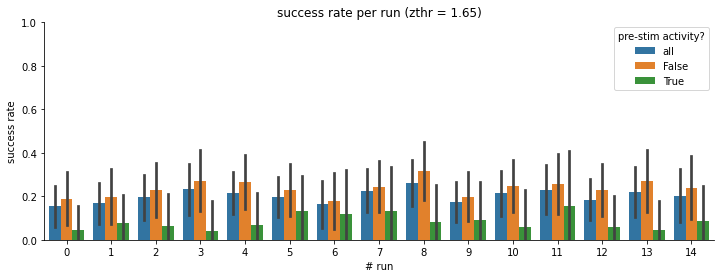

In [37]:
# Plot success rate per ROI & run
groupby = Label.PRESTIM_ACTIVITY
figs[f'sr_map'] = plot_stat_heatmap(
    Fstats, Label.IS_RESP, cmap='viridis', groupby=groupby)
# Plot success rate per ROI
figs['sr_per_ROI'] = plot_stat_per_ROI(
    Fstats, Label.IS_RESP,
    title=f'zthr = {REL_ZSCORE_RESPONSE_THR:.2f}', groupby=groupby)
# Plot success rate per run
figs['sr_per_run'] = plot_stat_per_run(
    Fstats, Label.IS_RESP,
    title=f'zthr = {REL_ZSCORE_RESPONSE_THR:.2f}', groupby=groupby)

### Compute corrected (response-only) z-scores

 24/11/2021 16:19:14: computing corrected z-scores (discarding no-response trials)...
 24/11/2021 16:19:29: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - all trials...
 24/11/2021 16:19:29: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - False trials...
 24/11/2021 16:19:29: plotting trial-averaged peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) per ROI & run - True trials...


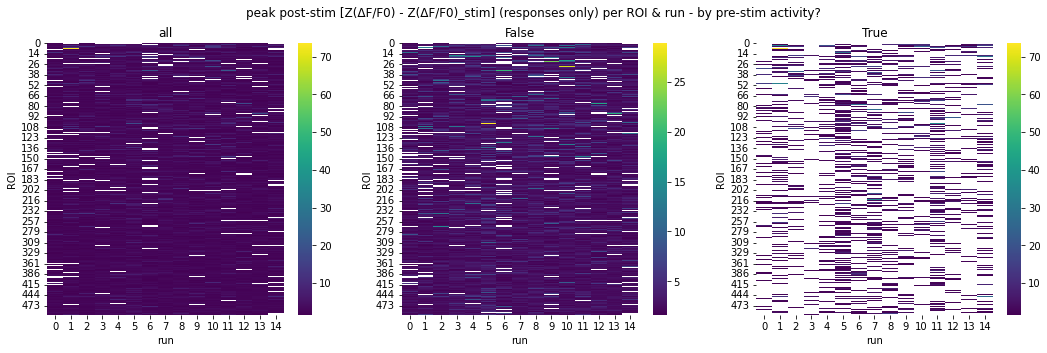

In [38]:
logger.info('computing corrected z-scores (discarding no-response trials)...')
# Extract z-scores from timeseries and stats tables
Ftimeseries[Label.REL_ZSCORE_RESPONLY] = Ftimeseries[Label.REL_ZSCORE]
Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = Fstats[Label.PEAK_REL_ZSCORE_POSTSTIM]
# Set no-response trials to NaN
noresp = ~Fstats[Label.IS_RESP]
Ftimeseries.loc[noresp, Label.REL_ZSCORE_RESPONLY] = np.nan
Fstats.loc[noresp, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY] = np.nan

# Plot corrected z-score per ROI & run
figs['corrected_peak_zscore_map'] = plot_stat_heatmap(
    Fstats, Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY, cmap='viridis',
    groupby=Label.PRESTIM_ACTIVITY)

### Classify response type per ROI

 24/11/2021 16:19:30: identifying "positive" runs for each ROI...
 24/11/2021 16:19:30: computing number of "positive" runs for each ROI...
 24/11/2021 16:19:30: classifying ROI response types...


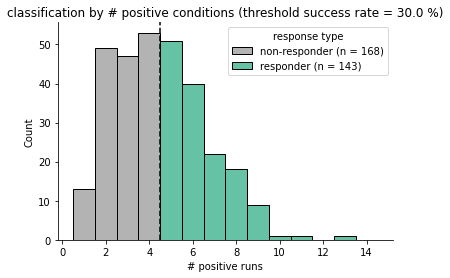

In [39]:
logger.info('identifying "positive" runs for each ROI...')
# Compute success rate over trials with no pre-stimulus activity
is_resp_noprestim = Fstats.loc[~Fstats[Label.PRESTIM_ACTIVITY], Label.IS_RESP]
sr = get_trial_averaged(is_resp_noprestim)
# Identify as "positive" runs those who are above a given success rate (for each ROI)
is_positive_run = sr > SUCCESS_RATE_THR

# Repeat along trial dimension in Fstats table
Fstats[Label.IS_POSITIVE_RUN] = repeat_along_new_dim(
    is_positive_run.to_frame(), 
    Label.TRIAL, index_dims[Label.TRIAL])

# Compute number of "positive" runs for each ROI
logger.info('computing number of "positive" runs for each ROI...')
n_positive_runs = is_positive_run.groupby(Label.ROI).sum().rename(Label.NPOS_RUNS)
# Repeat along run & trial dimensions in Fstats table
Fstats[Label.NPOS_RUNS] = repeat_along_new_dims(
    n_positive_runs.to_frame(), 
    {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# Assign response type to each ROI based on number of positive conditions
logger.info('classifying ROI response types...')
resp_types = (n_positive_runs >= NPOS_CONDS_THR).astype(int).rename(Label.ROI_RESP_TYPE)
resp_types = resp_types.map(LABEL_BY_TYPE)

# Repeat along run & trial dimensions in Fstats table
Fstats[Label.ROI_RESP_TYPE] = repeat_along_new_dims(
    resp_types.to_frame(), 
    {k: index_dims[k] for k in [Label.RUN, Label.TRIAL]})

# Plot the histogram of the number of positive conditions per response type
nruns = len(is_positive_run.index.unique(level=Label.RUN))
figs[Label.NPOS_RUNS] = plot_positive_runs_hist(
    n_positive_runs, resp_types, nruns,
    title=f'threshold success rate = {SUCCESS_RATE_THR * 1e2} %')

### Print Fstats table

In [40]:
logger.info('Fstats table:')
Fstats

 24/11/2021 16:19:30: Fstats table:


ΔF/F0 noise amplitude  ΔF/F0 noise level  \
ROI run trial                                             
0   0   1                   0.165741           0.231096   
        2                   0.165741           0.231096   
        3                   0.165741           0.231096   
        4                   0.165741           0.231096   
        5                   0.165741           0.231096   
...                              ...                ...   
514 14  11                  0.064915           0.102396   
        12                  0.064915           0.102396   
        13                  0.064915           0.102396   
        14                  0.064915           0.102396   
        15                  0.064915           0.102396   

               max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial                                              
0   0   1                  -0.515223               False   
        2                   0.708635               False   
        3                   2.074526                True   
        4                  -0.966680               False   
        5                   0.688474               False   
...                              ...                 ...   
514 14  11                  1.567126               False   
        12                  2.660599                True   
        13                  1.193217               False   
        14                  0.741079               False   
        15                  1.284842               False   

               peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  trial response?  \
ROI run trial                                                               
0   0   1                                       1.794584             True   
        2                                       1.919416             True   
        3                                       0.528048            False   
        4                                       1.752374             True   
        5                                       2.093622             True   
...                                                  ...              ...   
514 14  11                                     -0.518350            False   
        12                                     -4.236870            False   
        13                                     -3.093405            False   
        14                                     -1.211045            False   
        15                                     -2.575675            False   

               peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only)  \
ROI run trial                                                               
0   0   1                                               1.794584            
        2                                               1.919416            
        3                                                    NaN            
        4                                               1.752374            
        5                                               2.093622            
...                                                          ...            
514 14  11                                                   NaN            
        12                                                   NaN            
        13                                                   NaN            
        14                                                   NaN            
        15                                                   NaN            

               positive run?  # positive runs  response type  
ROI run trial                                                 
0   0   1               True                2  non-responder  
        2               True                2  non-responder  
        3               True                2  non-responder  
        4               True                2  non-responder  
        5               True                2  non-responder  
...                  

### Add everything to global data table

<span style="color:yellow">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [41]:
# Expand output table
logger.info('expanding output table along ROI, trial and frame dimensions...')
exp_output_table = output_info_table.copy()
for k in [Label.NPERTRIAL, Label.NTRIALS]:
    del exp_output_table[k]
exp_output_table = repeat_along_new_dims(
    exp_output_table,
    {k: index_dims[k] for k in [Label.ROI, Label.TRIAL, Label.FRAME]})
exp_output_table = exp_output_table.reorder_levels(list(index_dims.keys())).sort_index()
# Expand Fstats
logger.info('expanding Fstats along frame dimension...')
exp_Fstats = repeat_along_new_dim(Fstats, Label.FRAME, index_dims[Label.FRAME])
# Merge datasets
logger.info('merging datasets...')
data = pd.concat([exp_output_table, Ftimeseries, exp_Fstats], axis=1)
# Add time to dataset
data = add_time_to_table(data)
logger.info('data table:')
data

 24/11/2021 16:19:30: expanding output table along ROI, trial and frame dimensions...
 24/11/2021 16:19:36: expanding Fstats along frame dimension...
 24/11/2021 16:19:40: merging datasets...
 24/11/2021 16:19:43: adding time info to table...
 24/11/2021 16:19:46: data table:


time (s)   line  duration (s)  P (MPa)  DC (%)  run ID  \
ROI run trial frame                                                            
0   0   1     0      -2.808989  line3           0.2      0.0    50.0     757   
              1      -2.528090  line3           0.2      0.0    50.0     757   
              2      -2.247191  line3           0.2      0.0    50.0     757   
              3      -1.966292  line3           0.2      0.0    50.0     757   
              4      -1.685393  line3           0.2      0.0    50.0     757   
...                        ...    ...           ...      ...     ...     ...   
514 14  15    95     23.876404  line3           0.2      0.8    80.0     751   
              96     24.157303  line3           0.2      0.8    80.0     751   
              97     24.438202  line3           0.2      0.8    80.0     751   
              98     24.719101  line3           0.2      0.8    80.0     751   
              99     25.000000  line3           0.2      0.8    80.0     751   

                     F_ROI (a.u.)  F_neu (a.u.)   F (a.u.)  F0 (a.u.)  ...  \
ROI run trial frame                                                    ...   
0   0   1     0        168.144409    141.361465  71.510638  67.535671  ...   
              1        167.760254    142.605499  70.255664  67.535671  ...   
              2        171.451141    144.427521  72.671130  67.535671  ...   
              3        174.240143    144.644043  75.308566  67.535671  ...   
              4        170.864746    143.722931  72.577953  67.535671  ...   
...                           ...           ...        ...        ...  ...   
514 14  15    95       109.462318    103.979263  41.934222  37.603161  ...   
              96       111.942482    105.311058  43.482127  37.603161  ...   
              97       110.117363    105.131340  41.782817  37.603161  ...   
              98       108.078758    104.225807  40.378085  37.603161  ...   
              99       109.094688    105.140556  40.753688  37.603161  ...   

                     ΔF/F0 noise amplitude  ΔF/F0 noise level  \
ROI run trial frame                                             
0   0   1     0                   0.165741           0.231096   
              1                   0.165741           0.231096   
              2                   0.165741           0.231096   
              3                   0.165741           0.231096   
              4                   0.165741           0.231096   
...                                    ...                ...   
514 14  15    95                  0.064915           0.102396   
              96                  0.064915           0.102396   
              97                  0.064915           0.102396   
              98                  0.064915           0.102396   
              99                  0.064915           0.102396   

                     max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial frame                                              
0   0   1     0                  -0.515223               False   
              1                  -0.515223               False   
              2                  -0.515223               False   
              3                  -0.515223               False   
              4                  -0.515223               False   
...                                    ...                 ...   
514 14  15    95                  1.284842               False   
              96                  1.284842               False   
              97                  1.284842               False   
              98                  1.284842               False   
              99                  1.284842               False   

                     peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  \
ROI run trial frame                                              
0   0   1     0                                       1.794584   
              1                                       1.794584 

### Extract dataframe of trials without pre-stimulus activity

In [42]:
noprestim_data = data.loc[~data[Label.PRESTIM_ACTIVITY], :]
logger.info('data table of trials without pre-stimulus activity:')
noprestim_data

 24/11/2021 16:19:52: data table of trials without pre-stimulus activity:


time (s)   line  duration (s)  P (MPa)  DC (%)  run ID  \
ROI run trial frame                                                            
0   0   1     0      -2.808989  line3           0.2      0.0    50.0     757   
              1      -2.528090  line3           0.2      0.0    50.0     757   
              2      -2.247191  line3           0.2      0.0    50.0     757   
              3      -1.966292  line3           0.2      0.0    50.0     757   
              4      -1.685393  line3           0.2      0.0    50.0     757   
...                        ...    ...           ...      ...     ...     ...   
514 14  15    95     23.876404  line3           0.2      0.8    80.0     751   
              96     24.157303  line3           0.2      0.8    80.0     751   
              97     24.438202  line3           0.2      0.8    80.0     751   
              98     24.719101  line3           0.2      0.8    80.0     751   
              99     25.000000  line3           0.2      0.8    80.0     751   

                     F_ROI (a.u.)  F_neu (a.u.)   F (a.u.)  F0 (a.u.)  ...  \
ROI run trial frame                                                    ...   
0   0   1     0        168.144409    141.361465  71.510638  67.535671  ...   
              1        167.760254    142.605499  70.255664  67.535671  ...   
              2        171.451141    144.427521  72.671130  67.535671  ...   
              3        174.240143    144.644043  75.308566  67.535671  ...   
              4        170.864746    143.722931  72.577953  67.535671  ...   
...                           ...           ...        ...        ...  ...   
514 14  15    95       109.462318    103.979263  41.934222  37.603161  ...   
              96       111.942482    105.311058  43.482127  37.603161  ...   
              97       110.117363    105.131340  41.782817  37.603161  ...   
              98       108.078758    104.225807  40.378085  37.603161  ...   
              99       109.094688    105.140556  40.753688  37.603161  ...   

                     ΔF/F0 noise amplitude  ΔF/F0 noise level  \
ROI run trial frame                                             
0   0   1     0                   0.165741           0.231096   
              1                   0.165741           0.231096   
              2                   0.165741           0.231096   
              3                   0.165741           0.231096   
              4                   0.165741           0.231096   
...                                    ...                ...   
514 14  15    95                  0.064915           0.102396   
              96                  0.064915           0.102396   
              97                  0.064915           0.102396   
              98                  0.064915           0.102396   
              99                  0.064915           0.102396   

                     max pre-stim Z(ΔF/F0)  pre-stim activity?  \
ROI run trial frame                                              
0   0   1     0                  -0.515223               False   
              1                  -0.515223               False   
              2                  -0.515223               False   
              3                  -0.515223               False   
              4                  -0.515223               False   
...                                    ...                 ...   
514 14  15    95                  1.284842               False   
              96                  1.284842               False   
              97                  1.284842               False   
              98                  1.284842               False   
              99                  1.284842               False   

                     peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  \
ROI run trial frame                                              
0   0   1     0                                       1.794584   
              1                                       1.794584 

## Experiments summary results 

### Spatial distribution of cells per response type

 24/11/2021 16:19:56: extracting responses types per ROI...
 24/11/2021 16:19:58: plotting cells map color-coded by response type...


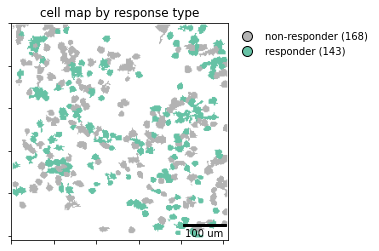

In [43]:
figs['cellmap'] = plot_cell_map(
    data, s2p_data, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'])

## Response traces

### Plot parameters


In [44]:
tbounds_response = [-2, 8.]  # s
ybounds_response = [-.2, .5]
plt_data = noprestim_data

### All traces for single ROI and condition

In [45]:
# iROIs_interactive = data.index.unique(level=Label.ROI)
# view_interactive_plot(
#     lambda i: plot_responses(
#         plt_data, iROI=iROIs_interactive[i], irun=irun_plt,
#         alltraces=True, ykey=Label.ZSCORE, label=Label.SUCCESS_RATE
#         mark_peaks=True, ci=None,
#         tbounds=tbounds_response),
#     len(iROIs_interactive));

### Visualize (ROI, run) combinations with best success rate

 24/11/2021 16:19:58: identified combinations with best success rate:
ROI  run
209  10     0.785714
249  11     0.727273
272  8      0.727273
Name: success rate, dtype: float64
 24/11/2021 16:19:58: sub-indexing data...
 24/11/2021 16:19:58: filtering data...
 24/11/2021 16:19:58: cross-checking filters...
 24/11/2021 16:19:58: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:19:58: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


1it [00:00, 33.56it/s]


 24/11/2021 16:20:00: sub-indexing data...
 24/11/2021 16:20:00: filtering data...
 24/11/2021 16:20:00: cross-checking filters...
 24/11/2021 16:20:00: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:20:00: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


 33%|███▎      | 1/3 [00:00<00:00, 39.38it/s]


 24/11/2021 16:20:01: sub-indexing data...
 24/11/2021 16:20:01: filtering data...
 24/11/2021 16:20:01: cross-checking filters...
 24/11/2021 16:20:01: averaging and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:20:01: plotting individual Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) traces...


 17%|█▋        | 1/6 [00:00<00:00, 31.75it/s]


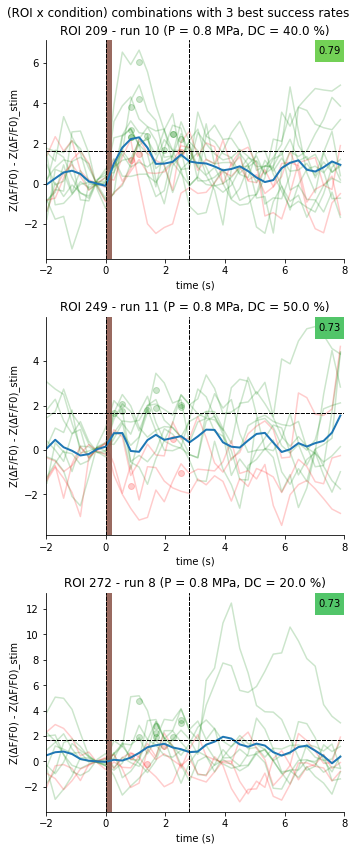

In [46]:
# Group by ROI and run, take first, sort by success rate, and select n bests 
best_sr = sr.sort_values(ascending=False).head(3)
logger.info(f'identified combinations with best success rate:\n{best_sr}')
ibests = best_sr.index.values
figs['best_responders'], axes = plt.subplots(len(ibests), 1, figsize=(5, len(ibests) * 4))
for (iROI, irun), ax in zip(ibests, axes):
    fig = plot_responses(
        plt_data, iROI=iROI, irun=irun,
        alltraces=True, ykey=Label.REL_ZSCORE, label=Label.SUCCESS_RATE,
        mark_peaks=True, ci=None,
        tbounds=tbounds_response, ax=ax)
fig.suptitle(f'(ROI x condition) combinations with {len(ibests)} best success rates')
fig.tight_layout()

### Response type, pressure & duty cycle dependency

 24/11/2021 16:20:03: sub-indexing data...
 24/11/2021 16:20:05: filtering data...
 24/11/2021 16:20:05: cross-checking filters...
 24/11/2021 16:20:06: grouping by response type, averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:20:36: sub-indexing data...
 24/11/2021 16:20:37: filtering data...
 24/11/2021 16:20:38: cross-checking filters...
 24/11/2021 16:20:38: grouping by response type, grouping by P (MPa), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:20:59: sub-indexing data...
 24/11/2021 16:21:01: filtering data...
 24/11/2021 16:21:02: cross-checking filters...
 24/11/2021 16:21:02: grouping by response type, grouping by DC (%), averaging, estimating confidence intervals and plotting mean Z(ΔF/F0) - Z(ΔF/F0)_stim vs. time (s) ...
 24/11/2021 16:21:28: sub-indexing data...
 24/11/2021 16:21:29: filtering data...
 24/11/2021 16:21:30: cross

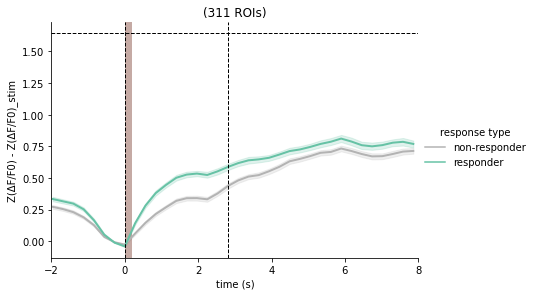

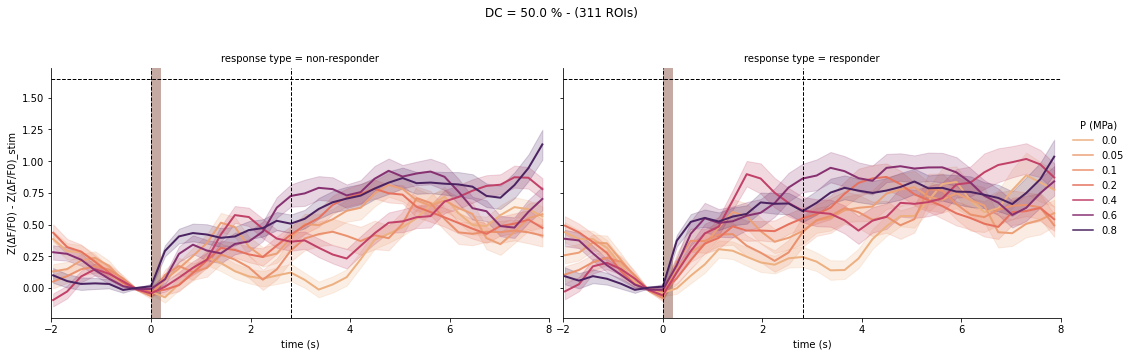

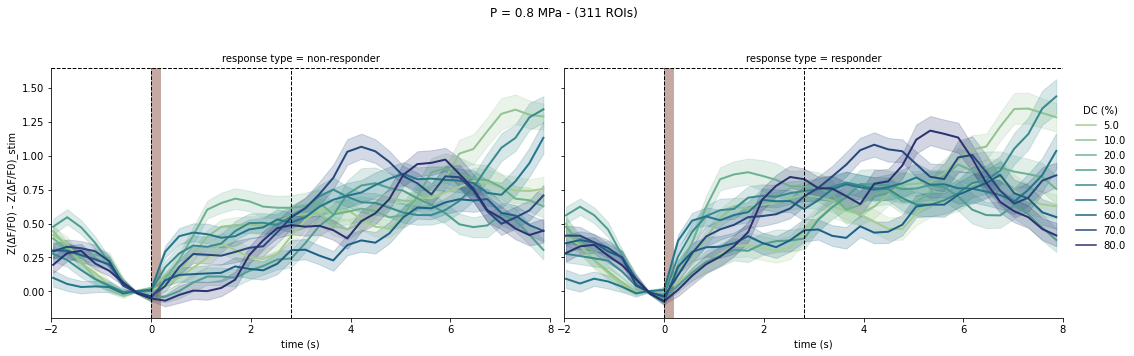

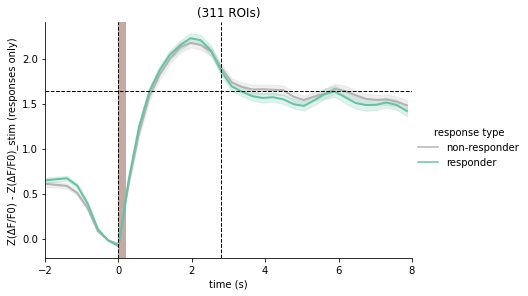

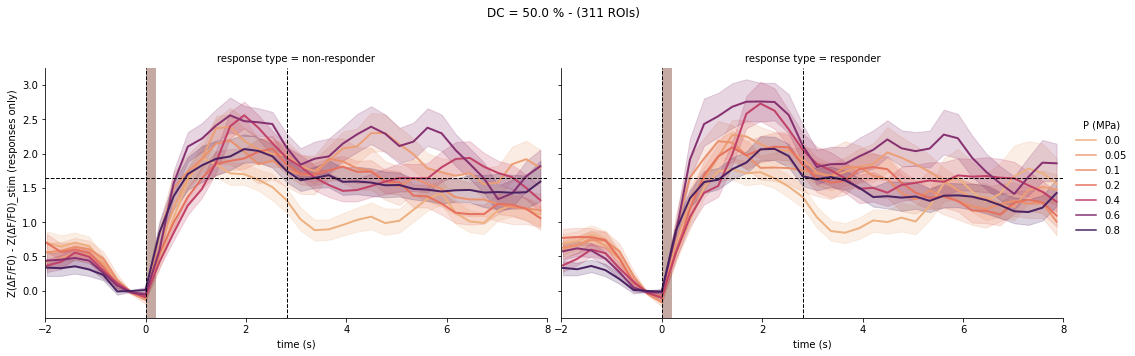

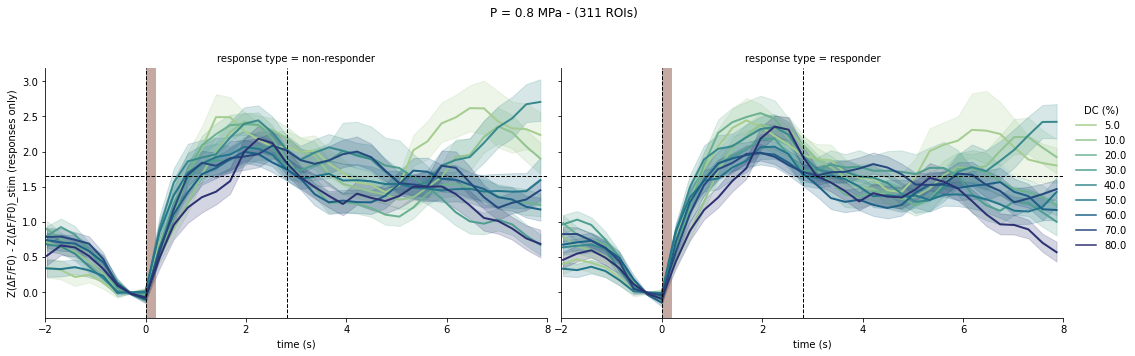

In [47]:
for ykey in [Label.REL_ZSCORE, Label.REL_ZSCORE_RESPONLY]:
    # Across conditions
    figs[f'responses_{ykey}_by_type'] = plot_responses(
        plt_data, ykey=ykey,
        hue=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response)

    # Pressure dependency
    figs[f'responses_{ykey}_by_type_DC{DC_REF}%'] = plot_responses(
        plt_data, DC=DC_REF, ykey=ykey,
        hue=Label.P, col=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response)

    # Duty cycle dependency
    figs[f'responses_{ykey}_by_type_P{P_REF}MPa'] = plot_responses(
        plt_data, P=P_REF, ykey=ykey,
        hue=Label.DC, col=Label.ROI_RESP_TYPE,
        tbounds=tbounds_response)

## Parameter dependency of response metrics

### Extract trial-averaged data

In [48]:
trialavg_data = get_trial_averaged(noprestim_data)
logger.info('trial-averaged data:')
trialavg_data

 24/11/2021 16:22:28: trial-averaged data:


line  duration (s)  P (MPa)  DC (%)  run ID  F_ROI (a.u.)  \
ROI run                                                               
0   0    line3           0.2     0.00    50.0   757.0    184.157944   
    1    line3           0.2     0.10    50.0   755.0    204.637009   
    2    line3           0.2     0.20    50.0   754.0    230.571518   
    3    line3           0.2     0.40    50.0   753.0    235.639328   
    4    line3           0.2     0.05    50.0   756.0    193.359894   
...        ...           ...      ...     ...     ...           ...   
514 10   line3           0.2     0.80    40.0   744.0    121.445160   
    11   line3           0.2     0.80    50.0   743.0    126.866631   
    12   line3           0.2     0.80    60.0   749.0    118.496765   
    13   line3           0.2     0.80    70.0   750.0    119.665230   
    14   line3           0.2     0.80    80.0   751.0    117.174850   

         F_neu (a.u.)    F (a.u.)  F0 (a.u.)     ΔF/F0  ...  \
ROI run                                                 ...   
0   0      140.679611   86.040241  67.535671  0.273997  ...   
    1      149.888474   98.026125  78.789009  0.244160  ...   
    2      153.969681  122.883309  95.868402  0.281792  ...   
    3      159.727448  124.497243  88.267834  0.410449  ...   
    4      145.473297   94.127672  76.195110  0.235351  ...   
...               ...         ...        ...       ...  ...   
514 10     112.790413   42.560398  38.466098  0.106439  ...   
    11     117.687531   44.520998  39.555481  0.125533  ...   
    12     107.485863   43.409850  39.912313  0.087631  ...   
    13     108.397316   43.787062  39.991834  0.094900  ...   
    14     107.969643   42.104051  37.603161  0.119694  ...   

         ΔF/F0 noise amplitude  ΔF/F0 noise level  max pre-stim Z(ΔF/F0)  \
ROI run                                                                    
0   0                 0.165741           0.231096              -0.249154   
    1                 0.133369           0.194751               0.389465   
    2                 0.164532           0.230221              -0.132295   
    3                 0.235844           0.380673               0.280721   
    4                 0.146750           0.171433              -0.214271   
...                        ...                ...                    ...   
514 10                0.056120           0.081374              -0.215125   
    11                0.066210           0.097801              -0.126463   
    12                0.048822           0.078355               0.490543   
    13                0.049015           0.078596               0.008732   
    14                0.064915           0.102396               0.700693   

         pre-stim rate  peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]  \
ROI run                                                             
0   0              0.0                                   0.623876   
    1              0.0                                  -0.113452   
    2              0.0                                   0.323549   
    3              0.0                                  -0.069656   
    4              0.0                                   0.161994   
...                ...                                        ...   
514 10             0.0                                   0.751128   
    11             0.0                                   2.805688   
    12             0.0                                   0.977671   
    13             0.0                                   0.773812   
    14             0.0                                  -1.081042   

         success rate  \
ROI run                 
0   0        0.384615   
    1        0.000000   
    2        0.083333   
    3        0.000000   
    4        0.000000   
...               ...   
514 10       0.250000   
    11       0.571429   
    12       0.363636   
    13       0.100000   
    14       0.000000   

         peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (r

### Success rate

 24/11/2021 16:22:28: sub-indexing data...
 24/11/2021 16:22:28: filtering data...
 24/11/2021 16:22:28: cross-checking filters...
 24/11/2021 16:22:28: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 24/11/2021 16:22:28: sub-indexing data...
 24/11/2021 16:22:28: filtering data...
 24/11/2021 16:22:28: cross-checking filters...
 24/11/2021 16:22:28: grouping by response type, averaging, estimating confidence intervals and plotting mean success rate vs. DC (%) ...


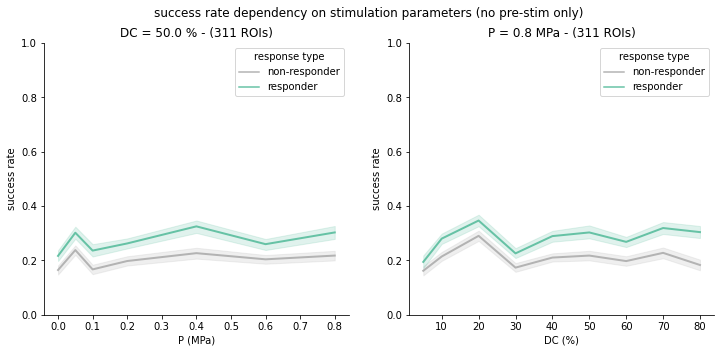

In [49]:
ykey = Label.SUCCESS_RATE
figs['success_rate_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes):
    fig = plot_parameter_dependency(
        trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, 1), hue=Label.ROI_RESP_TYPE,
        ax=ax)
fig.suptitle('success rate dependency on stimulation parameters (no pre-stim only)');

### Peak dFF z-score

 24/11/2021 16:22:28: sub-indexing data...
 24/11/2021 16:22:28: filtering data...
 24/11/2021 16:22:28: cross-checking filters...
 24/11/2021 16:22:28: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. P (MPa) ...
 24/11/2021 16:22:29: sub-indexing data...
 24/11/2021 16:22:29: filtering data...
 24/11/2021 16:22:29: cross-checking filters...
 24/11/2021 16:22:29: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs. DC (%) ...


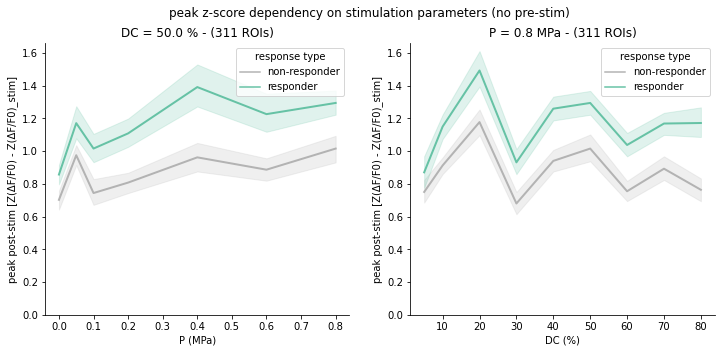

In [50]:
ykey = Label.PEAK_REL_ZSCORE_POSTSTIM
figs['peak_zscore_dependency'], axes = plt.subplots(1, 2, figsize=(12, 5))
for xkey, ax in zip([Label.P, Label.DC], axes.T):
    fig = plot_parameter_dependency(
        trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=Label.ROI_RESP_TYPE,
        ax=ax)
harmonize_axes_limits(axes)
fig.suptitle('peak z-score dependency on stimulation parameters (no pre-stim)');

### Peak dFF z-score (responses only, raw and weighted by success rate)

 24/11/2021 16:22:29: sub-indexing data...
 24/11/2021 16:22:29: filtering data...
 24/11/2021 16:22:29: cross-checking filters...
 24/11/2021 16:22:29: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. P (MPa) ...
 24/11/2021 16:22:30: sub-indexing data...
 24/11/2021 16:22:30: filtering data...
 24/11/2021 16:22:30: cross-checking filters...
 24/11/2021 16:22:30: grouping by response type, weighting by success rate, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. P (MPa) ...
 24/11/2021 16:22:30: sub-indexing data...
 24/11/2021 16:22:30: filtering data...
 24/11/2021 16:22:30: cross-checking filters...
 24/11/2021 16:22:30: grouping by response type, averaging, estimating confidence intervals and plotting mean peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] (responses only) vs. DC (%) ...
 24/11/2021 16:22:30: sub-

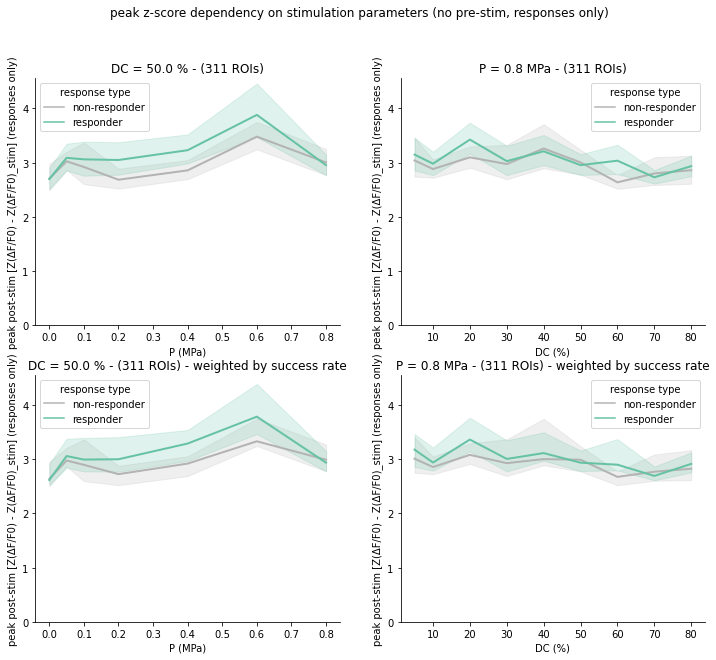

In [51]:
ykey = Label.PEAK_REL_ZSCORE_POSTSTIM_RESPONLY
figs['peak_zscore_responly_dependency'], axes = plt.subplots(2, 2, figsize=(12, 10))
for xkey, axrow in zip([Label.P, Label.DC], axes.T):
    for weightby, ax in zip([None, Label.SUCCESS_RATE], axrow):
        fig = plot_parameter_dependency(
            trialavg_data, xkey=xkey, ykey=ykey, ybounds=(0, None), hue=Label.ROI_RESP_TYPE,
            weightby=weightby, ax=ax)
harmonize_axes_limits(axes)
fig.suptitle('peak z-score dependency on stimulation parameters (no pre-stim, responses only)');

### Save figures

In [52]:
save_figs_book(figsdir, figs)

 24/11/2021 16:22:31: saving figure "dataset_info" on page 0
 24/11/2021 16:22:31: saving figure "raw_stack_run4" on page 1
 24/11/2021 16:22:31: saving figure "raw_stack_timecourse_run4" on page 2
 24/11/2021 16:22:31: saving figure "interp_stack_run4" on page 3
 24/11/2021 16:22:31: saving figure "interp_stack_timecourse_run4" on page 4
 24/11/2021 16:22:31: saving figure "filtered_stack_run4" on page 5
 24/11/2021 16:22:31: saving figure "filtered_stack_timecourse_run4" on page 6
 24/11/2021 16:22:31: saving figure "registered_images" on page 7
 24/11/2021 16:22:31: saving figure "registered_offsets" on page 8
 24/11/2021 16:22:32: saving figure "registered_stack_timecourse_run4" on page 9
 24/11/2021 16:22:32: saving figure "identified_ROIs" on page 10
 24/11/2021 16:22:32: saving figure "morpho_params_cells" on page 11
 24/11/2021 16:22:32: saving figure "filtered_ROIs" on page 12
 24/11/2021 16:22:32: saving figure "raw_F_traces" on page 13
 24/11/2021 16:22:33: saving figure "F_

### Save stacks as GIFs

In [53]:
# #raw and fileted stacks from specific run
# save_stack_to_gif(
#     figsdir, {'raw': raw_stack_fpaths[ifile], 'filtered': filtered_stack_fpaths[ifile]},
#     ilabels=i_stim_frames_run)
# # registered stack (slice corresponding to specific run)
# save_stack_to_gif(
#     figsdir, s2p_ops, title='registered',
#     ilabels=istimframes_stacked, bounds=runbounds)

### Notify upon completion

In [54]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'notebook completed in {tstamp_end - tstamp_start} s'
jupyter_slack.notify_self(s)
logger.info(s)

 24/11/2021 16:22:41: notebook completed in 0:05:00.876279 s
